# **Amazon Product Recommendation System**

We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context:**
--------------

Information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

We have the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. We have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095433 sha256=13d2a00e2a657fccb549bee79dfba8e987c915a7c7e38396296911a18e20b0af
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Importing the Dataset
- Adding column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Dropping the column timestamp
- Copying the data to another DataFrame called **df**

In [4]:
data = pd.read_csv('/content/drive/MyDrive/ADSP/ratings_Electronics.csv')

data.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
data.drop(columns='timestamp', axis = 1, inplace = True)

df = data.copy(deep=True)

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [5]:
# Getting the column containing the users
users = df.user_id

# Creating a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [6]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [7]:
# Getting the column containing the products
prods = df.prod_id

# Creating a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [8]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_prods = []

for prod, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_prods.append(prod)

df_final = df.loc[~ df.prod_id.isin(remove_prods)]

In [9]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

In [10]:
df_final.shape

(65290, 3)

**We removed the timestamp column and all users who have provided less than 50 total ratings, as well as all products that have received less than 5 ratings. This has reduced our dataframe substantially to ~65k rows and 3 columns - 'user_id', 'prod_id', and 'rating'. Rating exists as an ordinal observation from 1-5.**

### **Data types**

In [11]:
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

**Both 'user_id', and 'prod_id', are object datatypes. 'rating' is determined to be of float datatype.**

### **Checking for missing values**

In [12]:
df_final.isnull().value_counts()

user_id  prod_id  rating
False    False    False     65290
dtype: int64

**No missing values are present in the current dataframe. This is consistent since we iterated through users who have rated products, and products that have received ratings. Our current dataframe is a sample of actively contributing users and relatively popular products.**

### **Summary Statistics**

In [13]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Ratings range from 1 to 5. Summary statistics show the majority of ratings are between 4 and 5 as reflected by the IQR with median of 5 and a mean of 4.29. Only 25% of ratings are below a 4. Our dataframe is skewed towards higher, more positive, ratings.**

### **Checking the rating distribution**

<function matplotlib.pyplot.show(close=None, block=None)>

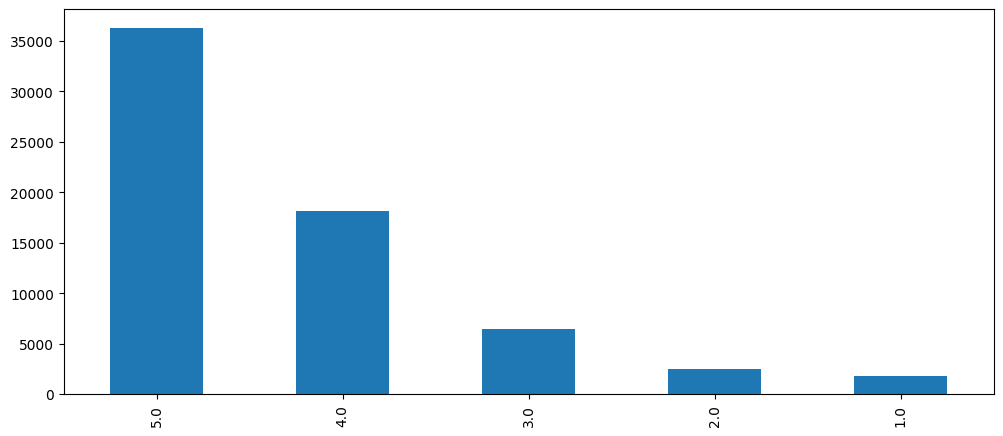

In [14]:
plt.figure(figsize = (12, 5))
df_final.rating.value_counts().plot(kind = 'bar')
plt.show


In [15]:
print('Ratings value counts:')
print(df_final.rating.value_counts())

Ratings value counts:
5.0    36315
4.0    18127
3.0     6481
2.0     2515
1.0     1852
Name: rating, dtype: int64


In [16]:
counts = df_final.rating.value_counts()
total = df_final.rating.value_counts().sum()

percentage = round((counts/total*100),2)
percentage

5.0    55.62
4.0    27.76
3.0     9.93
2.0     3.85
1.0     2.84
Name: rating, dtype: float64

**55.62% of our dataframe consists of rating '5'.**

**27.76% of our dataframe consists of rating '4'.**

**9.93% is of rating '3'.**

**3.85% is of rating '2'.**

**2.84% is of rating '1'.**

**This confirms our previous observation regarding the distribution of ratings:** 

**Positive ratings ('4','5') account for nearly 85% of our dataset.** 

**Negative ratings ('1','2') account for less than 7%.**

**Neutral ratings ('3') account for less than 10%.**

### **Checking the number of unique users and items in the dataset**

In [17]:
# Number of total rows in the data and number of unique user id and product id in the data
print('Total rows in dataset', df_final.shape[0])
print('Unique users in dataset: ', df_final.user_id.nunique())
print ('Unique products in dataset: ', df_final.prod_id.nunique())


Total rows in dataset 65290
Unique users in dataset:  1540
Unique products in dataset:  5689


**Our dataset consists of 1540 unique users and 5689 unique products.**

### **Users with the most number of ratings**

In [18]:
# Top 10 users based on the number of ratings
print('The top 10 users based on number of ratings: ', df_final.groupby(['user_id']).size().sort_values(ascending = False)[:10])


The top 10 users based on number of ratings:  user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64


In [19]:
df_final.groupby(['user_id']).size().sort_values(ascending = True)[:10]

user_id
A3DL29NLZ7SXXG    1
AP2NZAALUQKF5     1
A3MV1KKHX51FYT    1
A2BGZ52M908MJY    2
A16CVJUQOB6GIB    2
A2CL818RN52NWN    3
A1RCGK44YXNBBB    3
A2J4XMWKR8PPD0    3
A12DLJESJKM1OQ    4
A3P69DTOXII004    4
dtype: int64

**The user with the most ratings has given 295 ratings. The top 10 users with the most ratings range from 295 to 179.**

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [20]:
final_rating = pd.DataFrame()

# Calculating the average rating for each product 
final_rating['avg_ratings'] = df_final.groupby(['prod_id']).mean(['rating']).round(2)

# Calculating the count of ratings for each product
final_rating['rating_count'] = df_final.groupby(['prod_id']).size()

# Sorting the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(['avg_ratings'], ascending = False)

final_rating.head()

,avg_ratings,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B001EAQTRI,5.0,9
B001BTG3OQ,5.0,7
B00EKJQLSC,5.0,5
B00EKAPZ8S,5.0,8


In [21]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_prod(final_rating, n, min_interactions):
    
# Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count'] >= min_interactions]

# Sorting values with respect to average rating 
    recommendations = recommendations.sort_values(by='avg_ratings', ascending=False)

    return recommendations.index[:n]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [22]:
top_prod(final_rating, 5, 50)

Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='prod_id')

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [23]:
top_prod(final_rating, 5, 100)

Index(['B003ES5ZUU', 'B002WE6D44', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE'], dtype='object', name='prod_id')

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  


In [24]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [25]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # Mapping the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sorting user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) 
    
    print('Recall: ', recall) 
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

In [26]:
from surprise import Dataset, Reader

# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final, reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = .2,random_state = 1)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [27]:
# Declaring the similarity options
similarity_options = {'name': 'cosine', 'user_based': True}

# Initializing the KNNBasic model 
sim_uu_model = KNNBasic(sim_options = similarity_options, Verbose = False, random_state = 1)

# Fitting the model on the training data
sim_uu_model.fit(trainset)

# Computing precision@k, recall@k, and f_1 score 
precision_recall_at_k(sim_uu_model)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0260
Precision:  0.844
Recall:  0.862
F_1 score:  0.853


**Our Precision and Recall scores on our training data are good. This would mean that of the users being shown items, over 80% are relevant and over 80% of items recommended to the user are actually relevant. But, we also see an extremely high RMSE (>1) meaning the model is overfitting and unable to make reliable recommendations on new users.**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [28]:
# Predicting rating for a sample user with an interacted product
sim_uu_model.predict(uid = 'A3LDPF5FMB782Z', iid = '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

**Our model prediction for given user & item with an actual rating of 5 estimated a rating of 3.33. Our model's prediction has scored quite low here.**

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [29]:
# Finding unique user_id where prod_id is not equal to "1400501466"
df_final[df_final.prod_id != '1400501466'].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.** 

In [30]:
# Predicting rating for a sample user with a non interacted product
sim_uu_model.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 1.99   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=1.991150442477876, details={'actual_k': 2, 'was_impossible': False})

**Our model predicted this user would rate this unseen product a 1.99.**

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [31]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30, 40], 'min_k': [3, 6, 9, 12],
              'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
                              'user_based': [True]}}
              
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse', 'mae'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)


In [32]:
# Best RMSE score
print('best score: ', gs.best_score['rmse'])
print('-'*50)
# Combination of parameters that gave the best RMSE score
print('best parameters: ', gs.best_params['rmse'])

best score:  0.9715780692559631
--------------------------------------------------
best parameters:  {'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [33]:
# Using the optimal similarity measure for user-user based collaborative filtering
tuner = {'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}
sim_options = {'name': 'cosine', 'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_uu_model_tuned = KNNBasic(k = 40, min_k = 6, sim_options = sim_options, measures = ['rmse', 'mae'])
# Training the algorithm on the trainset
sim_uu_model_tuned.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [34]:
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_uu_model_tuned,)

RMSE: 0.9759
Precision:  0.834
Recall:  0.896
F_1 score:  0.864


**Our RMSE reduced from 1.026 to .9759 which is a modest improvement, at best. We improved our F1 score slightly, as well as Recall. Precision decreased slightly. Our tuned model has made slight improvements over the original.**

### **Steps:**
- **Predicting rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predicting rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Comparing the output with the output from the baseline model**

In [35]:
# Using optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_uu_model_tuned.predict('A3LDPF5FMB782Z', '1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

In [36]:
# Using optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_uu_model_tuned.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Our prediction for user 'A3LDPF5FMB782Z' rating on the same product did not change and remained at 3.33 where its actual was a rating of 5. Our predicted rating for user 'A34BZM6S9L7QI4' increased from 1.99 to 4.30 with our tuned model. Our tuned model identified user 'A34BZM6S9L7QI4' as being similar to 'A3LDPF5FMB782Z'.**

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [37]:
# 0 is the inner id of the above user
sim_uu_model_tuned.get_neighbors(0, k = 5)

[1, 10, 17, 18, 28]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [38]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [39]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, sim_uu_model_tuned)

In [40]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
rec_df = pd.DataFrame(data = recommendations, columns = ['prod_id', 'predicted_ratings'])
rec_df

,prod_id,predicted_ratings
0,B000067RT6,5
1,B001TH7GUU,5
2,B001UI2FPE,5
3,B001V9KG0I,5
4,B00316263Y,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [41]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': False}

# KNN algorithm is used to find desired similar items.
sim_ii_model = KNNBasic(sim_options = sim_options, random_state = 1)

# Training the algorithm on the trainset, and predicting ratings for the test set
sim_ii_model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_ii_model, k = 10)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0147
Precision:  0.826
Recall:  0.853
F_1 score:  0.839


**The performance baseline of our item-item similarity rec sys is comparable to our user-user model's baseline performance. We have a slightly worse RMSE but improved Precision, Recall, and F1 Score.**

**Previous user-user confusion matrix:**

**RMSE: 1.0260**



**Precision:  0.844**



**Recall:  0.862**



**F_1 score:  0.853**

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [42]:
# Retreiving actual rating
user = 'A3LDPF5FMB782Z'
prod = '1400501466'
single_id = df_final[df_final['user_id'] == user]
single_id = single_id[single_id['prod_id'] == prod]
print(single_id)

# item-item model prediction
sim_ii_model.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5.0)


             user_id     prod_id  rating
1309  A3LDPF5FMB782Z  1400501466     5.0


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.3, details={'actual_k': 20, 'was_impossible': False})

**Here we see an improvement in our prediction compared to our user-user similarity model. Our prediction estimated a rating of 4.3 versus the actual of 5.**

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [43]:
# Predicting rating for a sample user with a non interacted product
sim_ii_model.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.0, details={'actual_k': 4, 'was_impossible': False})

**Our model predicts this user will rate this item a 4.0**

### **Hyperparameter tuning the item-item similarity-based model**
- Useing the following values for the param_grid and tuning the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Using GridSearchCV() to tune the model using the 'rmse' measure
- Printing the best score and best parameters 

In [44]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}}
              
# Performing 3-fold cross-validation to tune the hyperparameters
gs_ii = GridSearchCV(KNNBasic, param_grid, measures = ['rmse', 'mae'], cv = 3, n_jobs = -1)

# Fitting the data
gs_ii.fit(data)

# Find the best RMSE score
print(gs_ii.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print(gs_ii.best_params['rmse'])

0.9750069148237323
{'k': 20, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Using the best parameters from GridSearchCV to build the optimized item-item similarity-based model.**

In [45]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options_tune = {'name': 'msd', 'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_ii_tuned = KNNBasic(k = 30, min_k = 6, sim_options = sim_options_tune, measures = ['rmse', 'mae'], random_state = 1)

# Training the algorithm on the trainset
sim_ii_tuned.fit(trainset)
# Computing precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_ii_tuned, k = 10)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9751
Precision:  0.829
Recall:  0.892
F_1 score:  0.859


**Basing our item-item similarity-based model using mean squared difference provided us a strong result. With a Recall of nearly 90% we are recommending items with 90% relevance. We should also consider information bubbles and feedback loops to leave room for a variety of new items to be recommended.**

### **Steps:**
- **Predicting rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predicting rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Comparing the output with the output from the baseline model**

In [46]:
# Using optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_ii_tuned.predict('A3LDPF5FMB782Z', '1400501466')

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.617647058823531, details={'actual_k': 20, 'was_impossible': False})

In [47]:
# Using optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_ii_tuned.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.296427477408486, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**We have made our best prediction so far with user A3LDPF5FMB782Z having an actual rating of 5 and our tuned item-item model predicting a rating of 4.62 by this user for the given item. User A34BZM6S9L7QI4 is predicted to have a very close score to the previous user but our prediction is telling us there aren't enough neighbors to make an accurate prediction.**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [48]:
sim_ii_tuned.get_neighbors(0, k = 5)

[2, 4, 9, 12, 13]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

In [49]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
item_recs = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_ii_tuned)

In [50]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
item_item_df = pd.DataFrame(item_recs, columns = ['prod_id', 'predicted_ratings'])
item_item_df.head()

,prod_id,predicted_ratings
0,1400532655,4.296427
1,1400599997,4.296427
2,9983891212,4.296427
3,B00000DM9W,4.296427
4,B00000J1V5,4.296427


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [51]:
# Using SVD matrix factorization
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(trainset)
# Computing precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.9104
Precision:  0.837
Recall:  0.88
F_1 score:  0.858


**Our baseline SVD model is giving us comparable scores to our previously tuned user-user and item-item models. We have a good RMSE score of .91 and F1 of .86. Hyperparameter tuning will likely increase our model's effectiveness.**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [52]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5.0)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.094312160755627, details={'was_impossible': False})

**Our baseline SVD model did not predict this user's rating as accurately as our tuned item-item model did. Actual rating = 5. SVD predicted rating = 4.09**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [53]:
# Making prediction
svd.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.051141373805704, details={'was_impossible': False})

**Our baseline SVD model appears to be more modestly predicting ratings when compared to our tuned item-item model. This could allow for strong recommendations without encountering information bubbles and feedback loops.**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [54]:
# Setting the parameter space to tune
svd_params = {'n_epochs': [5, 10,20,30,40], 'lr_all': [.001, .01, .1, .5, .9], 'reg_all': [.1, .2, .3, .4, .5, .6]}

# Performing 3-fold gridsearch cross-validation
svd_tuned = GridSearchCV(SVD, param_grid = svd_params, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fitting data
svd_tuned.fit(data)
# Best RMSE score
print(svd_tuned.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(svd_tuned.best_params['rmse'])

0.8967484748752735
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.3}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [55]:
# Building the optimized SVD model using optimal hyperparameter search
svd_model_tuned = SVD(n_epochs = 20, lr_all = .01, reg_all = .3, random_state = 1)
# Training the algorithm on the trainset
svd_model_tuned.fit(trainset) 
# Computing precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_model_tuned)

RMSE: 0.9016
Precision:  0.841
Recall:  0.884
F_1 score:  0.862


**Our tuned SVD model has made improvements over our baseline SVD model. RMSE improved from .91 to .90. Precision increased from .837 to .84. Recall improved from .88 to .884. F1 score improved from .858 to .862. Our improvements are modest using a tuned SVD model and matrix factorization.**

### **Steps:**
- **Predicting rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predicting rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Comparing the output with the output from the baseline model**

In [56]:
# Using optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_model_tuned.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5.0)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.028459972639957, details={'was_impossible': False})

In [57]:
# Using optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_model_tuned.predict('A34BZM6S9L7QI4', '1400501466')

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.068143256957646, details={'was_impossible': False})

### **Conclusion and Recommendations**

**We built 4 different recommendation systems:**
  **Rank-based on averages**
  **User-User Similarity-based collaborative filtering**
  **Item-Item Similarity-based collaborative filtering**
  **Matrix Factorization collaborative filtering**

**We tuned the hyperparameters of all 3 collaborative filtering models using gridsearch cross validation.**

**Our single best-performing model was our optimized User-User similarity-based collaborative filtering model with an F1 score of .864. Our optimized Matrix Factorization model was a close 2nd with an F1 score of .862.**

**Further hyperparameter tuning can improve our recommendations, as well as creating a hybrid system to incorporate a series of serialized, or parallel, recommendation systems would work best to provide relevant recommendations to users.**